# Fundamentals of Machine Learning - Exercise 4
* Goal of the excercise is to learn how to use **K-means** implementation in the Scikit-learn library to perform clustering and subsequent cluster analysis on a Titanic dataset.

## 🔎 Let's discuss the clustering topic a bit first
* What task do clustering algorithms solve?
* Do you know any examples of such algorithms?
* What are the limitation of clustering algorithms?

## 🔎 What is the **most difficult** of the clustering tasks?

![meme01](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_04_meme_01.jpg?raw=true)

## 💡 But don't worry we will deal with the topic in several lectures 😊

## Import the libraries
*🔎  What is the **sklearn** library?

In [2]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

# We will work with the famous Titanic dataset ⛵

## Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

* Dataset is available at https://www.kaggle.com/competitions/titanic'

## Load dataset
* https://raw.githubusercontent.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/master/datasets/titanic.csv

In [3]:
df = pd.read_csv('datasets/titanic.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## How many missing values do we have in the data?

In [4]:
df.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Name          0
Pclass        0
Survived      0
Sex           0
Parch         0
SibSp         0
Fare          0
Ticket        0
dtype: int64

## We are going to cluster the passangers into defined number of groups
* It is clear that it is mandatory to select only a relevant subset of features
    * Name the new DF as *df_clustering* 
* 🔎 Is *Name* or *Ticket* relevant?
    * 'Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'

1. Select the features
2. Drop *NaN* values
3. Change type of *Sex* and *Embarked* to string
    * **astype()** function

In [5]:
df.shape

(891, 11)

In [6]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
features = ['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
features

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [95]:
df[['Name', 'Ticket']].dtypes
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [9]:

df_clustering = df[features].copy()

# drop nan, either way is good
# df_clusterting = df_clusterting.dropna();
df_clustering.dropna(inplace=True);

df_clustering.Sex = df_clustering.Sex.astype("str")
df_clustering.Embarked = df_clustering.Embarked.astype("str")

df_clustering
# numbers should be normalized by some function: sigmoid, arctan


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


In [10]:
df_clustering[['Sex', 'Embarked']].dtypes

Sex         object
Embarked    object
dtype: object

## Check *shape* and *dtypes*

In [11]:
df_clustering.shape


(712, 8)

In [12]:
df_clustering.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

# Print the dataset

## 🔎 Does everything seem OK?

In [13]:
df_clustering

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


# We can see that not all features are numerical
* 🔎 Is it a problem?
    * Why?
* 🔎 How to deal with it?

## We have two basic encoding options
* Ordinal encoding vs. One-hot encoding
* What is the difference?
    * Is thete difference in dimensionality change? Why it can be an issue?
    * When is ordinal encoding appropriate?
    * Can you omit the pre-requirements of ordinal encoding sometimes?

## Lets encode categorical features
* https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
* https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing



In [14]:

enc = sklearn.preprocessing.OrdinalEncoder()
enc.fit_transform(df_clustering[['Sex']])[:20]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [15]:
df_clustering.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
7,0,1,male,54.0,0,0,51.8625,S
8,0,3,male,2.0,3,1,21.0750,S
9,1,3,female,27.0,0,2,11.1333,S
10,1,2,female,14.0,1,0,30.0708,C


In [16]:
df_clustering['Sex'].unique()
list(df_clustering['Sex'].unique())

['male', 'female']

In [17]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
categories = list(df_clustering['Sex'].unique())
enc = OrdinalEncoder(categories = [categories])

In [18]:
encoded_sex = enc.fit_transform(df_clustering[['Sex']])
encoded_sex[:10]

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]])

## 💡 You may ask why do we use the `dataframe[['feature_name']]` notation with double `[[` and `]]` brackets
* **Single brackets** pair around one variable name means that you want to select just the `pandas.Series` object

In [19]:
df_clustering['Sex'] = enc.fit_transform(df_clustering[['Sex']])

In [20]:
df_clustering.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0.0,22.0,1,0,7.2500,S
2,1,1,1.0,38.0,1,0,71.2833,C
3,1,3,1.0,26.0,0,0,7.9250,S
4,1,1,1.0,35.0,1,0,53.1000,S
5,0,3,0.0,35.0,0,0,8.0500,S
7,0,1,0.0,54.0,0,0,51.8625,S
8,0,3,0.0,2.0,3,1,21.0750,S
9,1,3,1.0,27.0,0,2,11.1333,S
10,1,2,1.0,14.0,1,0,30.0708,C


* **Double brackets** pair around one variable name created an output in the `pandas.DataFrame` format

In [21]:
df_clustering[['Sex']]

,Sex
PassengerId,
1,0.0
2,1.0
3,1.0
4,1.0
5,0.0
...,...
886,1.0
887,0.0
888,1.0


## There is OneHotEncoder as well, however I recommend using `pd.get_dummies` method instead

In [22]:
pd.get_dummies(df_clustering[['Embarked']])

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,False,False,True
2,True,False,False
3,False,False,True
4,False,False,True
5,False,False,True
...,...,...,...
886,False,True,False
887,False,False,True
888,False,False,True


In [23]:
df_clustering[['Embarked']]

,Embarked
PassengerId,
1,S
2,C
3,S
4,S
5,S
...,...
886,Q
887,S
888,S


In [24]:
embarked_categories = list(df_clustering['Embarked'].unique())
embarked_categories

['S', 'C', 'Q']

In [25]:
oh_enc = OneHotEncoder(categories = [embarked_categories])
oh_enc

,categories,"[['S', 'C', ...]]"
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [26]:
fitted = oh_enc.fit_transform(df_clustering[['Embarked']])
fitted

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 712 stored elements and shape (712, 3)>

In [27]:
pd.get_dummies(df_clustering[['Embarked']], dtype=float)

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
...,...,...,...
886,0.0,1.0,0.0
887,0.0,0.0,1.0
888,0.0,0.0,1.0


In [28]:
pd.get_dummies(df_clustering['Embarked'], dtype=float)

,C,Q,S
PassengerId,,,
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
...,...,...,...
886,0.0,1.0,0.0
887,0.0,0.0,1.0
888,0.0,0.0,1.0


In [29]:
df_test = df_clustering.copy()
OneHotEncoder().fit_transform(df_clustering[['Sex', 'Embarked']])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1424 stored elements and shape (712, 5)>

## Let's finish the encoding part and create a new dataframe with encoded data
1. Create empty *df_encoded* dataframe with index using *df_clustering.index*
2. Create *Sex* variable with ordinal encoded data
3. Use `join` method for added one-hot encoded *Embarked* feature

In [30]:
df_encoded = pd.DataFrame(index = df_clustering.index);
df_encoded

""
PassengerId
1
2
3
4
5
...
886
887
888


In [31]:
df_encoded['Sex'] = OrdinalEncoder().fit_transform(df_clustering[['Sex']])
df_encoded

,Sex
PassengerId,
1,0.0
2,1.0
3,1.0
4,1.0
5,0.0
...,...
886,1.0
887,0.0
888,1.0


In [32]:
pd.get_dummies(df_clustering[['Embarked']], dtype=float)

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
...,...,...,...
886,0.0,1.0,0.0
887,0.0,0.0,1.0
888,0.0,0.0,1.0


In [33]:
df_encoded = df_encoded.join(pd.get_dummies(df_clustering[['Embarked']], dtype=float))
df_encoded

,Sex,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,
1,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0
5,0.0,0.0,0.0,1.0
...,...,...,...,...
886,1.0,0.0,1.0,0.0
887,0.0,0.0,0.0,1.0
888,1.0,0.0,0.0,1.0


# It is important to select the appropriate scaling method of the number features
* There are many ways how to do this - **MinMax, StandardScaler, PowerTransform, ...**
* This step heavily depends on a domain knowledge because the scales of the features have significant effect on a distances between couples of dataset instances
    - It is clear that if one variable is in range **(0,1)** and the second one is in a range **(5000, 10 000)**, the difference in the **second feature** will be definitely **more important** than in the  first one from the numerical point of view
    - Although it is possible that from the **domain point of view** the **first variable may be more important**
    - 💡 Thus it is a good idea to at least transform the features into a **simiiar scales so the effect on the distance value would be similiar**
    - Transformation depends heavily on the statistical distribution of the feature
        - 💡You can use PowerTransform for a heavy-tailed distribution, **Standardization or MinMax normalization for normally distributed features** etc.

## Take a look at the *Fare* feature distribution
* What transformation would be appropriate based on that?

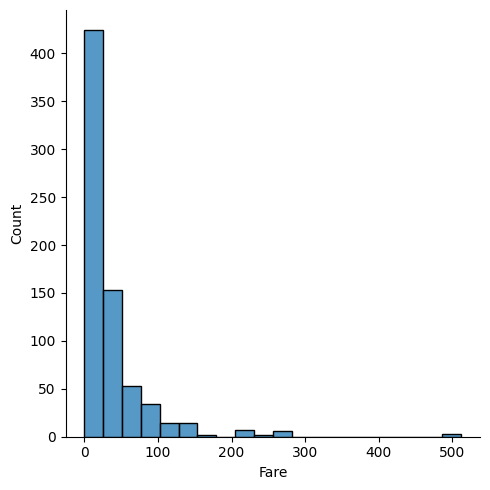

In [34]:
sns.displot(df_clustering.Fare, bins=20)

## Transform the feature

In [35]:
df_clustering[['Fare']]

,Fare
PassengerId,
1,7.2500
2,71.2833
3,7.9250
4,53.1000
5,8.0500
...,...
886,29.1250
887,13.0000
888,30.0000


In [36]:
enc = sklearn.preprocessing.PowerTransformer()
power_transformed_fare = enc.fit_transform(df_clustering[['Fare']])
power_transformed_fare[:10]

array([[-0.9976503 ],
       [ 1.28775742],
       [-0.90107255],
       [ 1.02427568],
       [-0.88411158],
       [ 1.00273178],
       [ 0.13202716],
       [-0.53475875],
       [ 0.48661961],
       [-0.10705646]])

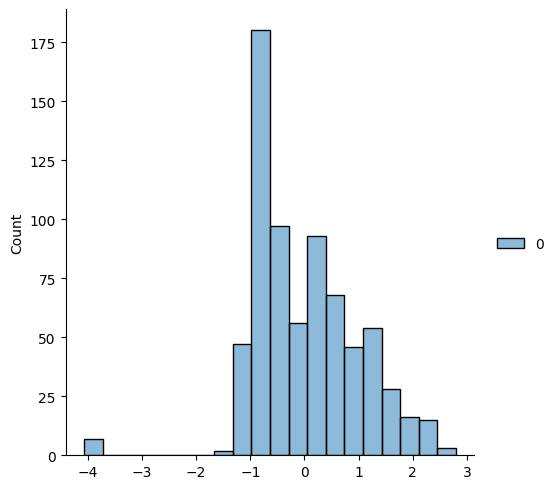

In [37]:
sns.displot(power_transformed_fare, bins=20)

## Add the transformed feature into the *df_encoded* dataframe

In [38]:

enc = sklearn.preprocessing.PowerTransformer()
fare_scaled = enc.fit_transform(df_clustering[['Fare']])
df_encoded['Fare'] = fare_scaled 

In [39]:
df_encoded.head(10)

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare
PassengerId,,,,,
1,0.0,0.0,0.0,1.0,-0.997650
2,1.0,1.0,0.0,0.0,1.287757
3,1.0,0.0,0.0,1.0,-0.901073
4,1.0,0.0,0.0,1.0,1.024276
5,0.0,0.0,0.0,1.0,-0.884112
7,0.0,0.0,0.0,1.0,1.002732
8,0.0,0.0,0.0,1.0,0.132027
9,1.0,0.0,0.0,1.0,-0.534759
10,1.0,1.0,0.0,0.0,0.486620


## Plot histogram of the transformer feature
* 🔎 What has changed?

<Axes: xlabel='Fare', ylabel='Count'>

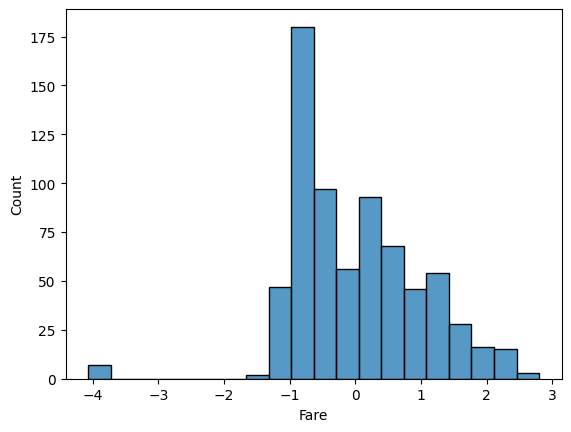

In [40]:
sns.histplot(df_encoded.Fare, bins=20)

## Scale the *Age* using MinMax scaler
* `sklearn.preprocessing.minmax_scale`

In [41]:
df_clustering[['Age']]

,Age
PassengerId,
1,22.0
2,38.0
3,26.0
4,35.0
5,35.0
...,...
886,39.0
887,27.0
888,19.0


In [42]:
age_feature_range = (df_clustering.Age.min(), df_clustering.Age.max())
enc = sklearn.preprocessing.MinMaxScaler(feature_range = (0,1)) # age_feature_range)
scaled_age = enc.fit_transform(df_clustering[['Age']])
scaled_age[:10]

array([[0.27117366],
       [0.4722292 ],
       [0.32143755],
       [0.43453129],
       [0.43453129],
       [0.67328474],
       [0.01985423],
       [0.33400352],
       [0.17064589],
       [0.04498618]])

In [43]:
df_encoded['Age'] = scaled_age
df_encoded.head(10)

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age
PassengerId,,,,,,
1,0.0,0.0,0.0,1.0,-0.997650,0.271174
2,1.0,1.0,0.0,0.0,1.287757,0.472229
3,1.0,0.0,0.0,1.0,-0.901073,0.321438
4,1.0,0.0,0.0,1.0,1.024276,0.434531
5,0.0,0.0,0.0,1.0,-0.884112,0.434531
7,0.0,0.0,0.0,1.0,1.002732,0.673285
8,0.0,0.0,0.0,1.0,0.132027,0.019854
9,1.0,0.0,0.0,1.0,-0.534759,0.334004
10,1.0,1.0,0.0,0.0,0.486620,0.170646


## Join the *df_encoded* and *['Survived', 'Pclass', 'SibSp', 'Parch']* features

In [44]:
features = ['Survived', 'Pclass', 'SibSp', 'Parch']

In [45]:
# df_encoded.drop(columns=features)

In [46]:
df_clustering[features]

,Survived,Pclass,SibSp,Parch
PassengerId,,,,
1,0,3,1,0
2,1,1,1,0
3,1,3,0,0
4,1,1,1,0
5,0,3,0,0
...,...,...,...,...
886,0,3,0,5
887,0,2,0,0
888,1,1,0,0


In [47]:
df_encoded = df_encoded.join(df_clustering[features])
df_encoded

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age,Survived,Pclass,SibSp,Parch
PassengerId,,,,,,,,,,
1,0.0,0.0,0.0,1.0,-0.997650,0.271174,0,3,1,0
2,1.0,1.0,0.0,0.0,1.287757,0.472229,1,1,1,0
3,1.0,0.0,0.0,1.0,-0.901073,0.321438,1,3,0,0
4,1.0,0.0,0.0,1.0,1.024276,0.434531,1,1,1,0
5,0.0,0.0,0.0,1.0,-0.884112,0.434531,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...
886,1.0,0.0,1.0,0.0,0.455301,0.484795,0,3,0,5
887,0.0,0.0,0.0,1.0,-0.369789,0.334004,0,2,0,0
888,1.0,0.0,0.0,1.0,0.484313,0.233476,1,1,0,0


# We finally got to the clustering part 😮‍💨

![meme02](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_04_meme_02.jpg?raw=true)

## There are methods how to identify probable number of clusters in the data
* It is always a rough estimate

## 💡 We can use **Elbow method** to identify potentially ideal number of clusters in our data in **KMeans** algorithm.

There are two basic methods for evaluation of clusters quality:
1. SSE - Sum of squared distances of samples to their closest cluster center, this one is specific for **KMeans** algorithm.
    * You can find it as **inertia_** attribute of KMeans sklearn object.
2. Silhouette Coefficient - calculated using the mean intra-cluster distance and the mean nearest-cluster distance

## 💡 We ussually want to find number of clusters with low SSE and high Silhoutte coef.
- Take a look at [this](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) and [this](https://towardsdatascience.com/k-means-clustering-from-a-to-z-f6242a314e9a) for more details

## Try different number of clusters from range <2, 10> for KMeans algorithm, save both evaluation criteria and plot dependency of criteria to number of clusters.
* We will use `sklearn.cluster.KMeans` class
* The most important parameter is the *n_clusters*
    * What is the *random_state* parameter?

In [48]:
X = df_encoded.values
X

array([[0., 0., 0., ..., 3., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 3., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 3., 0., 0.]], shape=(712, 10))

In [49]:
clustering_scores = []

# try out for 2 to 10 clusters
for k in range(2, 20):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=14)
    clustering = kmeans.fit(X)

    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })

df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')

In [50]:
df_clustering_scores

,sse,silhouette
k,,
2,2051.762019,0.334082
3,1557.666411,0.368968
4,1379.352124,0.301751
5,1281.782259,0.282775
6,1126.954225,0.282349
7,1044.967183,0.273627
8,978.010537,0.265234
9,913.559359,0.267112
10,886.390785,0.266584


In [51]:
kmeans = sklearn.cluster.KMeans(n_clusters=3, random_state=14)
clustering = kmeans.fit(X)
clustering.labels_

array([1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2,
       2, 2, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 2,
       2, 1, 0, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0,
       0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0,

## Plot the SSE and Silhouette score

<Axes: xlabel='k', ylabel='sse'>

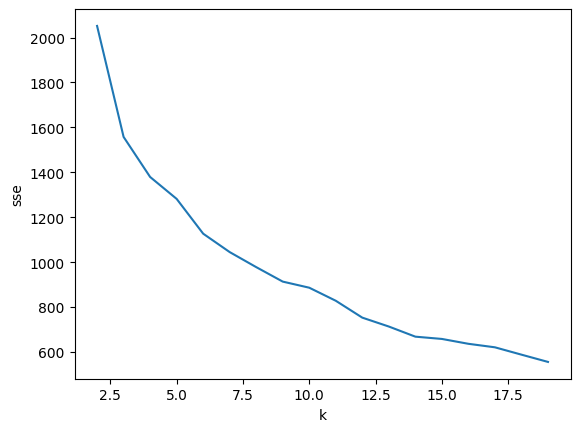

In [52]:
sns.lineplot(data = df_clustering_scores, 
             x='k',
             y='sse', 
             )

<Axes: xlabel='k', ylabel='silhouette'>

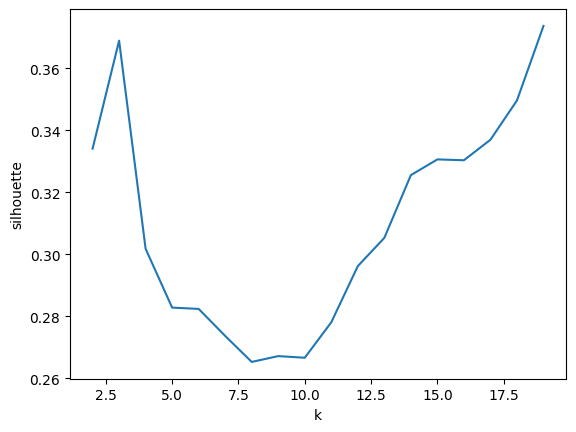

In [53]:
sns.lineplot(data = df_clustering_scores, 
             x='k',
             y='silhouette', 
             )

# 🔎 What is the probable number of clusters in the data?

## Let's try to analyze the data assigned into **4** clusters 

In [54]:
kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=13)
clustering = kmeans.fit(X)
sklearn.metrics.silhouette_score(X, clustering.labels_)

0.3798803296295334

## How big are our clusters? How many 0, 1, .. are in *labels_* property?

In [55]:
clustering.labels_

array([0, 1, 0, 1, 0, 1, 2, 3, 1, 0, 1, 0, 3, 0, 0, 2, 0, 0, 0, 0, 1, 2,
       3, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 1, 1, 1, 0, 0, 3,
       2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 3,
       2, 0, 0, 0, 1, 3, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 2,
       3, 3, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 2, 2, 3, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0,
       3, 1, 1, 0, 1, 0, 3, 3, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1,
       1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 3, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1,

In [56]:
clustering.labels_.shape

(712,)

In [57]:
pd.Series(clustering.labels_).value_counts()

0    396
1    229
2     44
3     43
Name: count, dtype: int64

# 📒 Explore clusters
* Try to use cluster information for exploration analysis of our data
    * Create new feature *cluster_id* with the *labels_* property data

In [58]:
df_clustering['cluster_id'] = clustering.labels_
df_clustering

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_id
PassengerId,,,,,,,,,
1,0,3,0.0,22.0,1,0,7.2500,S,0
2,1,1,1.0,38.0,1,0,71.2833,C,1
3,1,3,1.0,26.0,0,0,7.9250,S,0
4,1,1,1.0,35.0,1,0,53.1000,S,1
5,0,3,0.0,35.0,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...,...
886,0,3,1.0,39.0,0,5,29.1250,Q,3
887,0,2,0.0,27.0,0,0,13.0000,S,0
888,1,1,1.0,19.0,0,0,30.0000,S,1


## 🚀 Hint: You can use *sns.countplot* as a visual *.value_counts()* method

<Axes: xlabel='cluster_id', ylabel='count'>

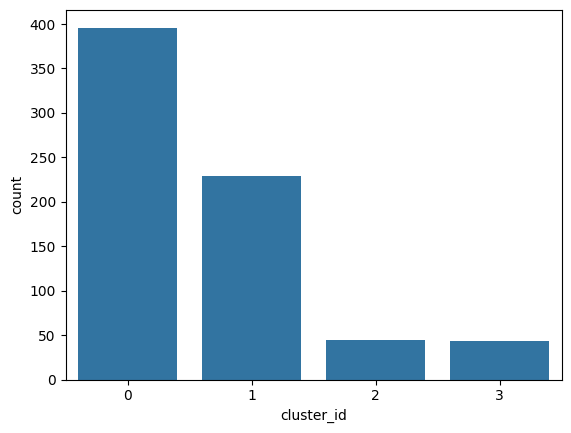

In [59]:
sns.countplot(df_clustering, x='cluster_id')

## 🎯 Create plots showing values of different attributes based on cluster group and describe them
* Let's follow the four example questions about the data to solve the task

### ❓ Questions ❓
1. Is **Fare** different for points in different clusters?
    * 💡 Use *plt.yscale('log')* to take care of the outlier/variance effect
2. Is **Age** different for point in different clusters?
3. Does rate of suvival differ in clusters?
    * *Survived*
4. Does number of passanger of each class differ in clusters?
    * *Pclass*

<Axes: xlabel='Age', ylabel='Fare'>

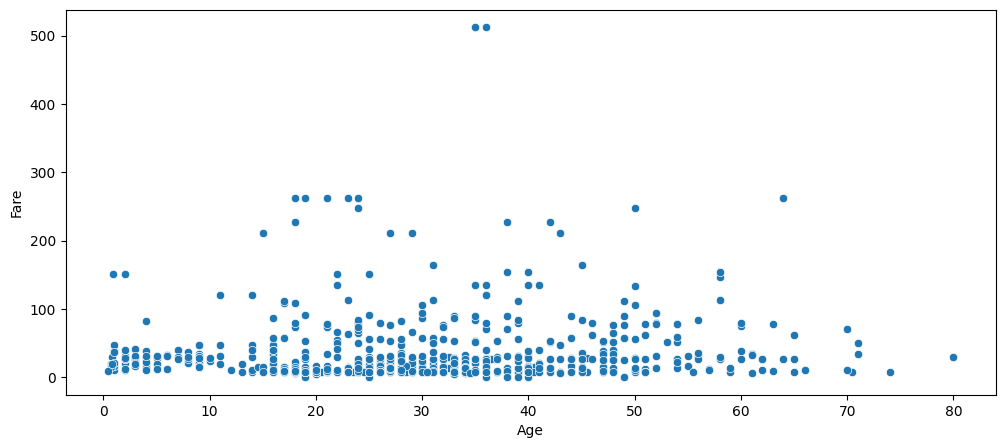

In [60]:
plt.figure(figsize=(12, 5))
sns.scatterplot(df_clustering, y='Fare', x='Age')

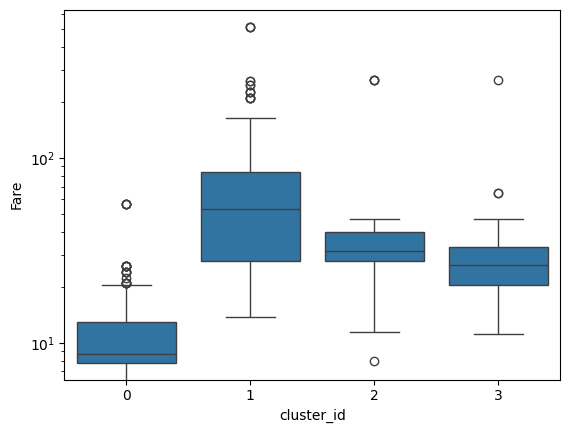

In [61]:
sns.boxplot(
    df_clustering, 
    x = 'cluster_id',
    y ='Fare', 
)
# squashes the outliers
plt.yscale('log')

<Axes: xlabel='cluster_id', ylabel='Age'>

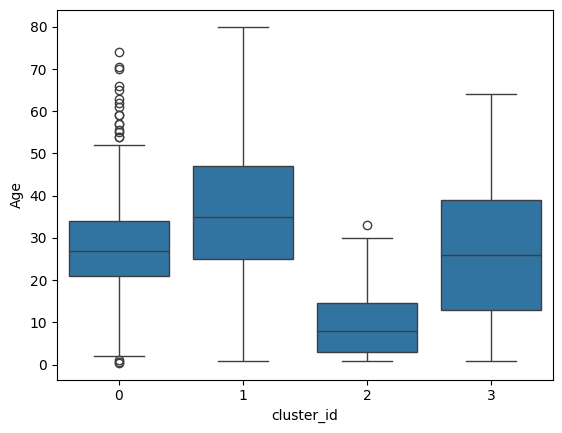

In [62]:
sns.boxplot(df_clustering, x='cluster_id', y='Age')

<Axes: xlabel='cluster_id', ylabel='count'>

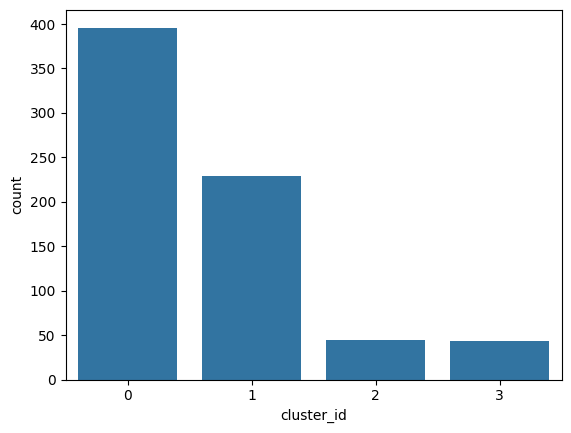

In [63]:
sns.countplot(df_clustering, x = 'cluster_id')

<Axes: xlabel='cluster_id', ylabel='count'>

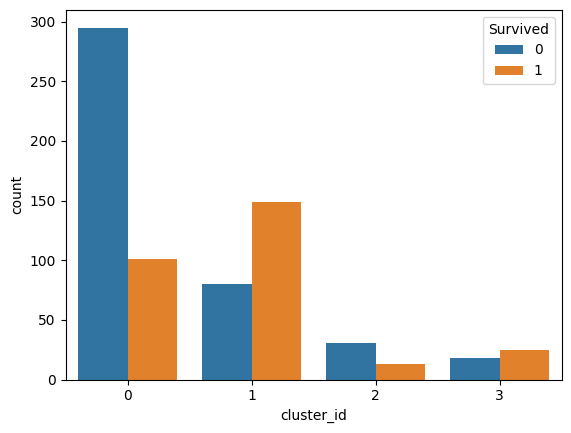

In [64]:
sns.countplot(df_clustering, x = 'cluster_id', hue = 'Survived')

<Axes: xlabel='Survived', ylabel='count'>

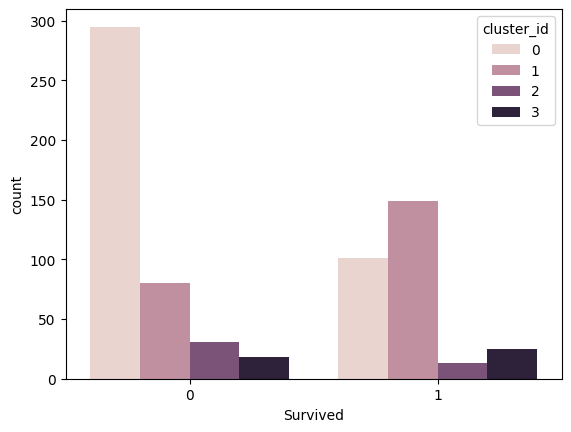

In [65]:
sns.countplot(df_clustering, x = 'Survived', hue = 'cluster_id')

<Axes: xlabel='cluster_id', ylabel='count'>

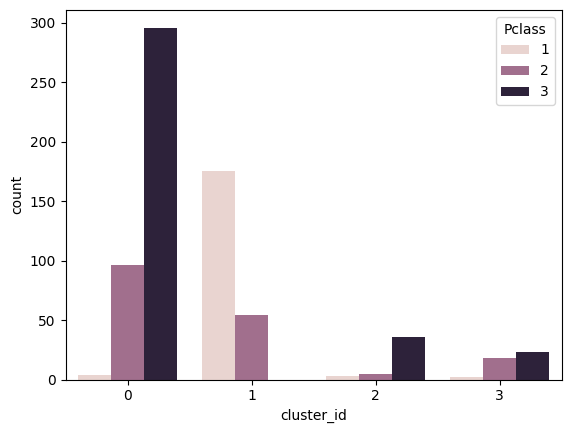

In [66]:
sns.countplot(df_clustering, x = 'cluster_id', hue = 'Pclass')

<Axes: xlabel='Pclass', ylabel='count'>

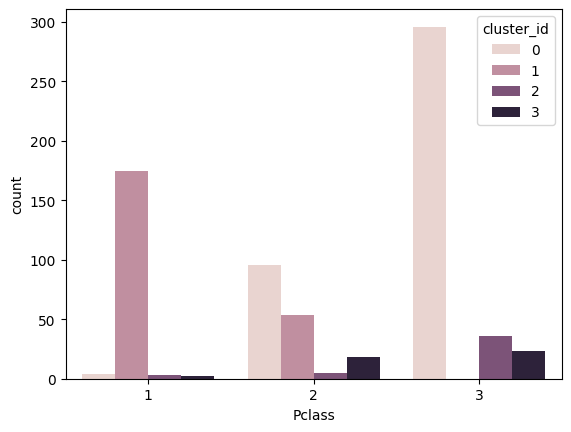

In [67]:
sns.countplot(df_clustering, x = 'Pclass', hue = 'cluster_id')

# 📝 Write a textual description of the four clusters

### Cluster 1 - ...
### Cluster 2 - ...
### Cluster 3 - ...
### Cluster 4 - ...

# Is our data represented in the best way?

* **Clustering methods depends on calculation of distance metric among data points in our data matrix.**
* Therefore it is necessary to preproces our data matrix **X** in a best way possible to achive equal distance for every dataset feature. 
    * After such transformation we can presume, that difference in *Age* has same impact as the difference as in the *Fare* feature.
* **Generally, it is very hard to create perfect tranformation for our real dataset.**

## Use StandardScaler transformation for our data **X**

In [68]:
col_names = ['Fare', 'Age', 'SibSp', 'Parch']

enc = sklearn.preprocessing.StandardScaler()

df_clustering.loc[:, col_names].head(10)

,Fare,Age,SibSp,Parch
PassengerId,,,,
1,7.2500,22.0,1,0
2,71.2833,38.0,1,0
3,7.9250,26.0,0,0
4,53.1000,35.0,1,0
5,8.0500,35.0,0,0
7,51.8625,54.0,0,0
8,21.0750,2.0,3,1
9,11.1333,27.0,0,2
10,30.0708,14.0,1,0


In [69]:
X_std = pd.DataFrame(enc.fit_transform(df_clustering.loc[:, col_names]), 
                     columns = col_names, 
                     index = df_clustering.index
                    )
X_std

,Fare,Age,SibSp,Parch
PassengerId,,,,
1,-0.516380,-0.527669,0.522511,-0.506787
2,0.694046,0.577094,0.522511,-0.506787
3,-0.503620,-0.251478,-0.552714,-0.506787
4,0.350326,0.369951,0.522511,-0.506787
5,-0.501257,0.369951,-0.552714,-0.506787
...,...,...,...,...
886,-0.102875,0.646142,-0.552714,5.350885
887,-0.407687,-0.182430,-0.552714,-0.506787
888,-0.086335,-0.734812,-0.552714,-0.506787


In [70]:
X_std.describe()

,Fare,Age,SibSp,Parch
count,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02
mean,-6.736185e-17,2.943962e-16,-1.496930e-17,1.496930e-17
std,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00
min,-6.534272e-01,-2.017717e+00,-5.527137e-01,-5.067874e-01
25%,-5.012575e-01,-6.657639e-01,-5.527137e-01,-5.067874e-01
50%,-3.576726e-01,-1.133826e-01,-5.527137e-01,-5.067874e-01
75%,-2.962586e-02,5.770939e-01,5.225108e-01,6.647471e-01
max,9.031168e+00,3.477095e+00,4.823409e+00,6.522419e+00


In [71]:
X_std = pd.concat(
            [X_std, df_encoded.loc[:, ['Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S']], df_clustering.Survived], 
            axis = 1
        )
X_std

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
PassengerId,,,,,,,,,
1,-0.516380,-0.527669,0.522511,-0.506787,0.0,0.0,0.0,1.0,0
2,0.694046,0.577094,0.522511,-0.506787,1.0,1.0,0.0,0.0,1
3,-0.503620,-0.251478,-0.552714,-0.506787,1.0,0.0,0.0,1.0,1
4,0.350326,0.369951,0.522511,-0.506787,1.0,0.0,0.0,1.0,1
5,-0.501257,0.369951,-0.552714,-0.506787,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...
886,-0.102875,0.646142,-0.552714,5.350885,1.0,0.0,1.0,0.0,0
887,-0.407687,-0.182430,-0.552714,-0.506787,0.0,0.0,0.0,1.0,0
888,-0.086335,-0.734812,-0.552714,-0.506787,1.0,0.0,0.0,1.0,1


In [72]:
X_std.describe()

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
count,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,712.000000,712.000000,712.000000,712.000000,712.000000
mean,-6.736185e-17,2.943962e-16,-1.496930e-17,1.496930e-17,0.363764,0.182584,0.039326,0.778090,0.404494
std,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,0.481420,0.386597,0.194506,0.415823,0.491139
min,-6.534272e-01,-2.017717e+00,-5.527137e-01,-5.067874e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.012575e-01,-6.657639e-01,-5.527137e-01,-5.067874e-01,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-3.576726e-01,-1.133826e-01,-5.527137e-01,-5.067874e-01,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-2.962586e-02,5.770939e-01,5.225108e-01,6.647471e-01,1.000000,0.000000,0.000000,1.000000,1.000000
max,9.031168e+00,3.477095e+00,4.823409e+00,6.522419e+00,1.000000,1.000000,1.000000,1.000000,1.000000


# ✅ Task (2p)
1. Use **KMeans** to differently preprocessed data matrix **X_stand**
2. Detect "ideal" number of clusters using Elbow method
3. Explore detected clusters and **describe** them to the Markdown cell
    * **Describe the insight you got from the plots with a few sentences in a Markdown cell below the plot**
        * ❌ Plot interpretation figured in real-time during task check is not allowed! ❌

In [73]:
# minimize sse and maximize silhouette
clustering_scores = []

# try out for a to b number of 
# using more clusters is probably just overfitting
for k in range(2, 200):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=14)

    clustering = kmeans.fit(X_std)

    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X_std, clustering.labels_)
    })

df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')

In [74]:
df_clustering_scores

,sse,silhouette
k,,
2,2614.505804,0.406254
3,2245.478942,0.265557
4,1900.785297,0.247743
5,1609.453578,0.270458
6,1454.026069,0.282249
...,...,...
195,52.115374,0.415708
196,51.081653,0.416594
197,50.512006,0.417176


# Overfitted model

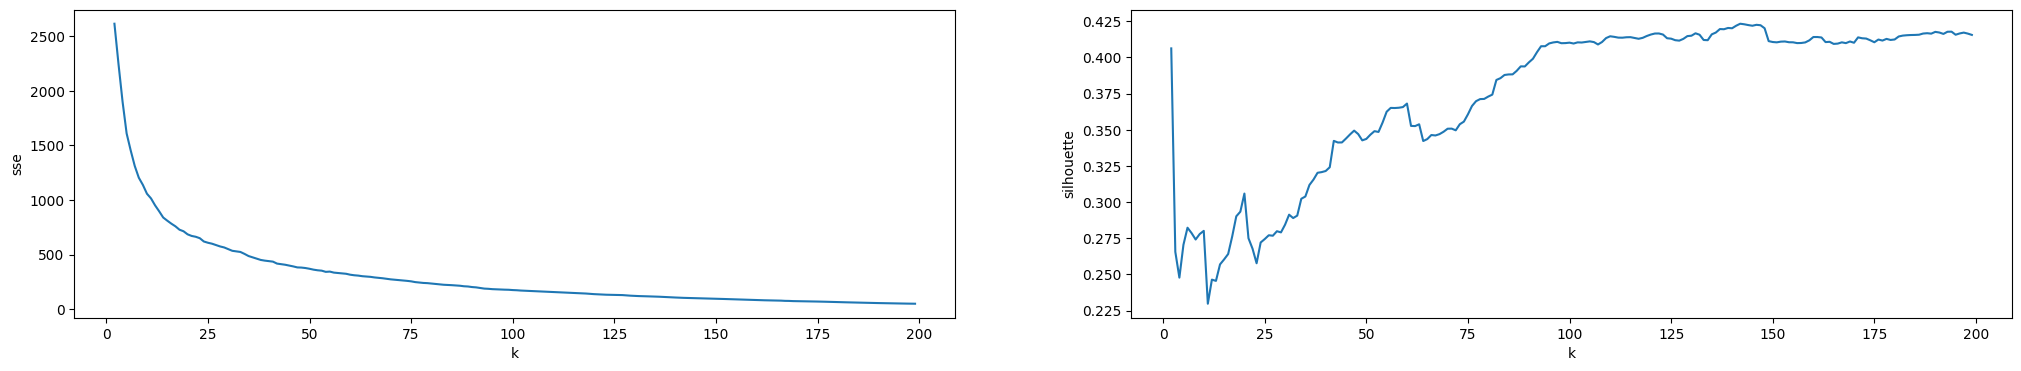

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

sns.lineplot(df_clustering_scores.sse, ax=axes.flat[0])
sns.lineplot(df_clustering_scores.silhouette, ax=axes.flat[1])
plt.show()


# Normal amount = 6

In [76]:
X_std

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
PassengerId,,,,,,,,,
1,-0.516380,-0.527669,0.522511,-0.506787,0.0,0.0,0.0,1.0,0
2,0.694046,0.577094,0.522511,-0.506787,1.0,1.0,0.0,0.0,1
3,-0.503620,-0.251478,-0.552714,-0.506787,1.0,0.0,0.0,1.0,1
4,0.350326,0.369951,0.522511,-0.506787,1.0,0.0,0.0,1.0,1
5,-0.501257,0.369951,-0.552714,-0.506787,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...
886,-0.102875,0.646142,-0.552714,5.350885,1.0,0.0,1.0,0.0,0
887,-0.407687,-0.182430,-0.552714,-0.506787,0.0,0.0,0.0,1.0,0
888,-0.086335,-0.734812,-0.552714,-0.506787,1.0,0.0,0.0,1.0,1


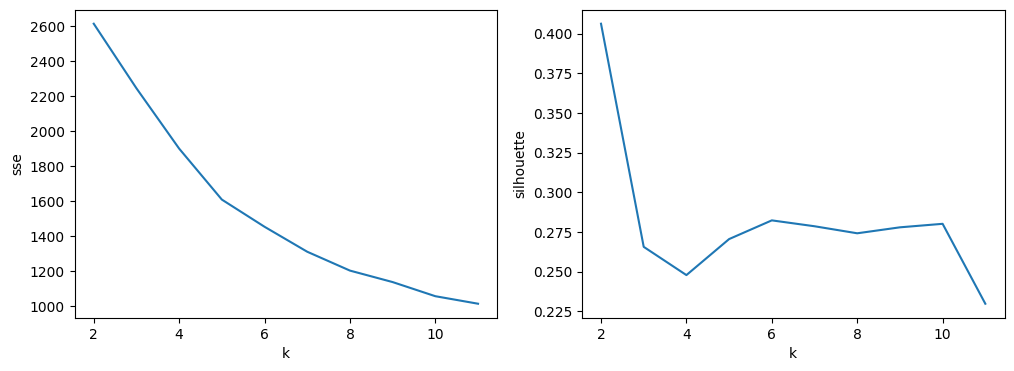

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.lineplot(df_clustering_scores.sse[:10], ax=axes.flat[0])
sns.lineplot(df_clustering_scores.silhouette[:10], ax=axes.flat[1])
plt.show()


In [78]:
df_clustering_scores.silhouette[:10]

k
2     0.406254
3     0.265557
4     0.247743
5     0.270458
6     0.282249
7     0.278540
8     0.274104
9     0.277863
10    0.280075
11    0.229688
Name: silhouette, dtype: float64

In [79]:
kmeans = sklearn.cluster.KMeans(n_clusters = 6, random_state = 14)
clustering = kmeans.fit(X_std)
sklearn.metrics.silhouette_score(X_std, clustering.labels_)

0.2822486862159491

In [80]:
clustering.labels_.shape

(712,)

In [81]:
pd.Series(clustering.labels_).value_counts()

3    375
0    157
2    102
1     34
4     32
5     12
Name: count, dtype: int64

In [82]:
# X_std are value from df_clustering
df_clustering['cluster_id'] = clustering.labels_
df_clustering.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_id
PassengerId,,,,,,,,,
1,0,3,0.0,22.0,1,0,7.2500,S,3
2,1,1,1.0,38.0,1,0,71.2833,C,0
3,1,3,1.0,26.0,0,0,7.9250,S,3
4,1,1,1.0,35.0,1,0,53.1000,S,3
5,0,3,0.0,35.0,0,0,8.0500,S,3
7,0,1,0.0,54.0,0,0,51.8625,S,0
8,0,3,0.0,2.0,3,1,21.0750,S,4
9,1,3,1.0,27.0,0,2,11.1333,S,2
10,1,2,1.0,14.0,1,0,30.0708,C,3


<Axes: xlabel='cluster_id', ylabel='count'>

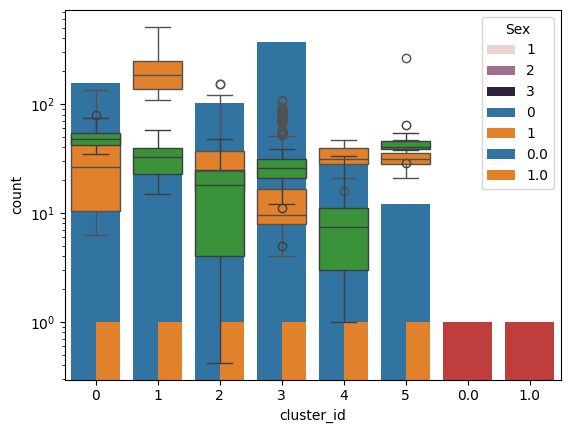

In [83]:
# Count
sns.countplot(data=df_clustering, x='cluster_id')

# Fare
plt.yscale('log')
sns.boxplot(data=df_clustering, x='cluster_id', y='Fare')

# P class
sns.countplot(data=df_clustering, x='cluster_id', hue='Pclass')

# Survived
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

# Age
sns.boxplot(data=df_clustering, x='cluster_id', y='Age')

# Sex
sns.countplot(data=df_clustering, x='Sex')

# Sex
sns.countplot(data=df_clustering, x='cluster_id', hue='Sex')

In [84]:
df_clustering.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'cluster_id'],
      dtype='object')

In [85]:
enc = OrdinalEncoder(categories=[df_clustering.Embarked.unique()])
df_clustering_fitted = df_clustering.copy() 
df_clustering_fitted['Embarked'] = enc.fit_transform(df_clustering_fitted[['Embarked']])

In [86]:
df_clustering_fitted.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_id
PassengerId,,,,,,,,,
1,0,3,0.0,22.0,1,0,7.2500,0.0,3
2,1,1,1.0,38.0,1,0,71.2833,1.0,0
3,1,3,1.0,26.0,0,0,7.9250,0.0,3
4,1,1,1.0,35.0,1,0,53.1000,0.0,3
5,0,3,0.0,35.0,0,0,8.0500,0.0,3


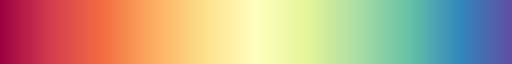

In [87]:
sns.color_palette('Spectral', as_cmap=True)

<Axes: >

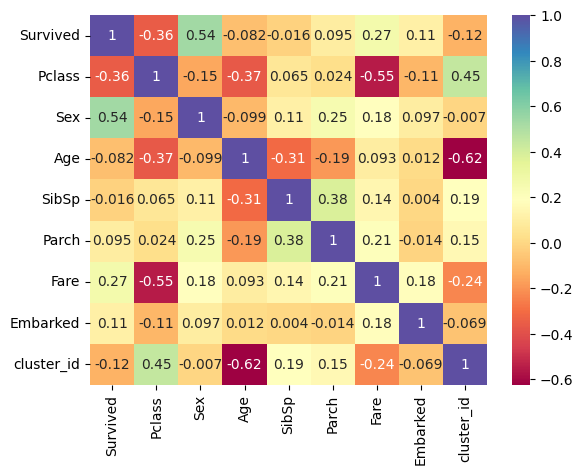

In [88]:
sns.heatmap(df_clustering_fitted.corr(), cmap=sns.color_palette('Spectral', as_cmap=True), annot=True)

<Axes: xlabel='cluster_id', ylabel='count'>

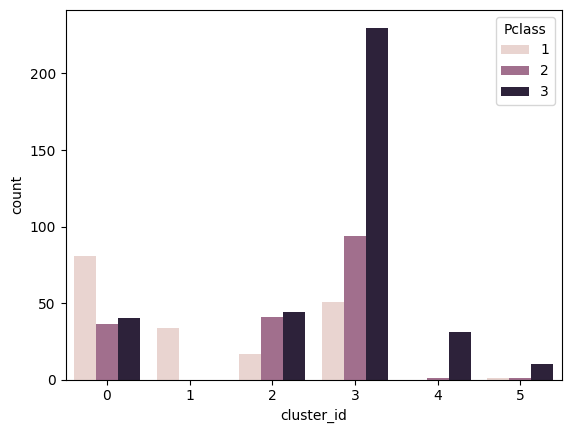

In [89]:
sns.countplot(df_clustering, x='cluster_id', hue='Pclass')

<Axes: xlabel='cluster_id', ylabel='count'>

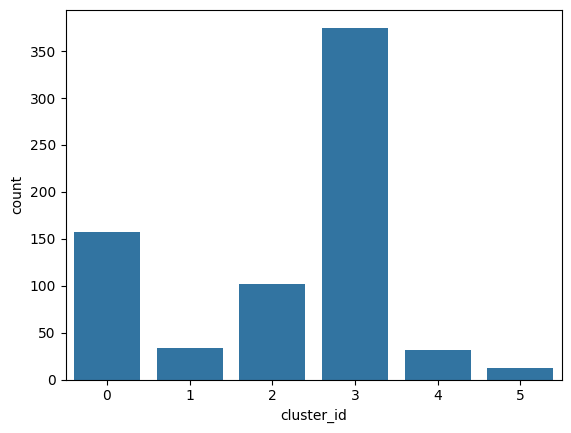

In [90]:
sns.countplot(data=df_clustering, x='cluster_id')

<Axes: xlabel='cluster_id', ylabel='Fare'>

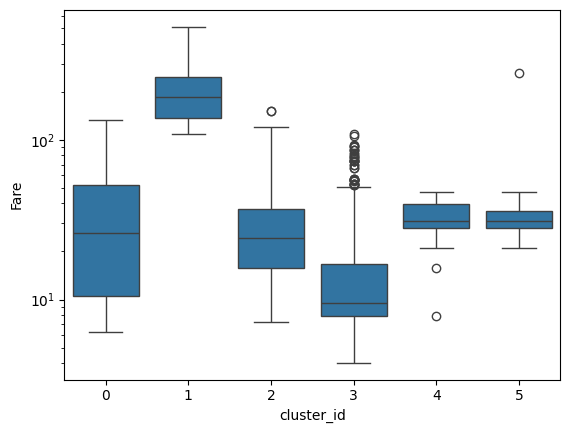

In [91]:
plt.yscale('log')
sns.boxplot(data=df_clustering, x='cluster_id', y='Fare')

<Axes: xlabel='Pclass', ylabel='count'>

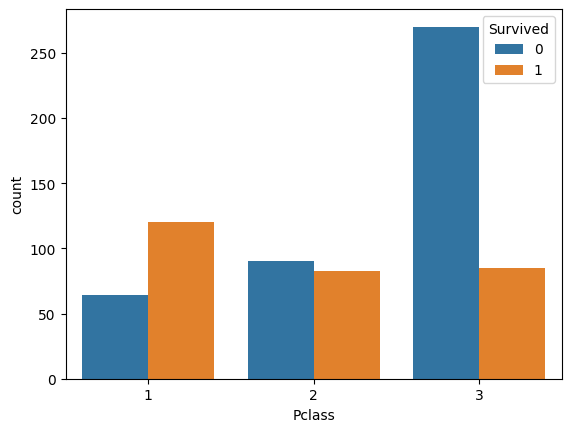

In [92]:
sns.countplot(data=df_clustering, x='Pclass', hue='Survived')

In [94]:
df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


<Axes: xlabel='cluster_id', ylabel='count'>

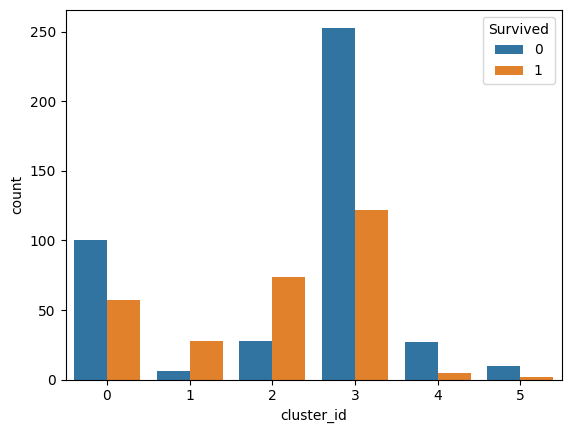

In [180]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

<Axes: xlabel='cluster_id', ylabel='Age'>

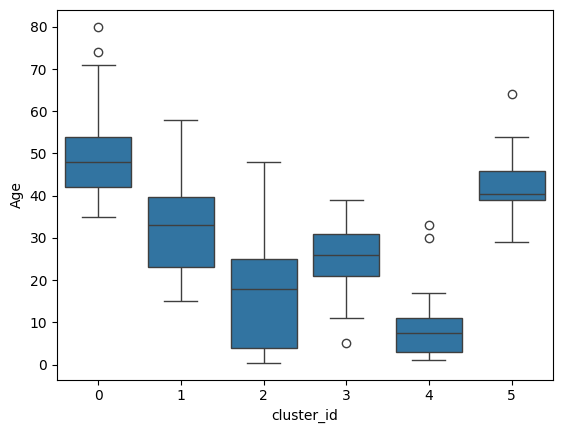

In [182]:
sns.boxplot(data=df_clustering, x='cluster_id', y='Age')

In [183]:
df_clustering.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'cluster_id'],
      dtype='object')

<Axes: xlabel='Sex', ylabel='count'>

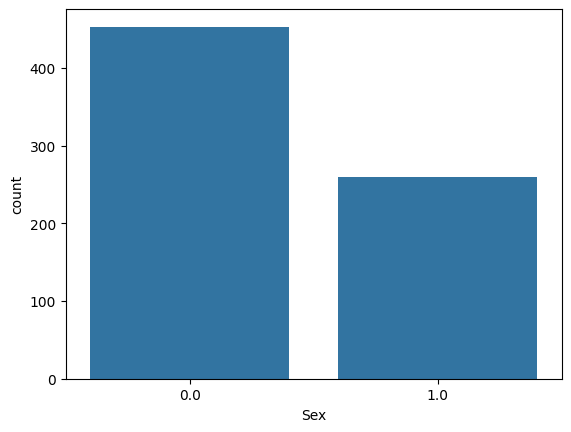

In [186]:
sns.countplot(data=df_clustering, x='Sex')

In [188]:
df_clustering.Sex.value_counts()

Sex
0.0    453
1.0    259
Name: count, dtype: int64

<Axes: xlabel='cluster_id', ylabel='count'>

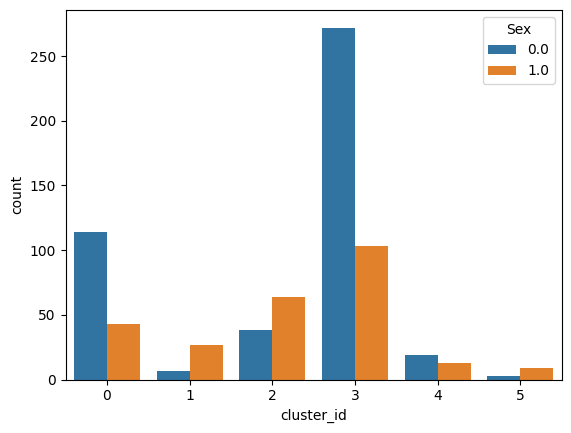

In [184]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Sex')